In [1]:
import numpy as np
import scarlet

In [2]:
test = 0.5*np.ones((3,3))
test[1,1] = 1
test[0,0] = test[2,0] = test[0,2] = test[2,2] = 0

In [4]:
dx = .25
dy = .1
test = np.arange(9, dtype=float).reshape(3,3)

Gamma = scarlet.transformations.oldGammaOp()
tx,tx_plus,tx_minus,ty,ty_plus,ty_minus,P = Gamma._make_matrices((1,*test.shape), [0,0])
Txp = tx-dx*tx_plus
Typ = ty-dy*ty_plus
Txm = tx+dx*tx_minus
Tym = ty+dy*ty_minus
oldTx = np.array([
    Txp.dot(Typ).dot(test.flatten()).reshape(test.shape),
    Txp.dot(Tym).dot(test.flatten()).reshape(test.shape),
    Txm.dot(Typ).dot(test.flatten()).reshape(test.shape),
    Txm.dot(Tym).dot(test.flatten()).reshape(test.shape),
    (Txp.dot(Typ)).T.dot(test.flatten()).reshape(test.shape),
    Txp.T.dot(test.flatten()).reshape(test.shape),
    Typ.T.dot(test.flatten()).reshape(test.shape),
])
print(test)

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]]


In [5]:
ltpp = scarlet.transformations.LinearTranslation(dy, dx)
ltpm = scarlet.transformations.LinearTranslation(-dy, dx)
ltmp = scarlet.transformations.LinearTranslation(dy, -dx)
ltmm = scarlet.transformations.LinearTranslation(-dy, -dx)
ltx = scarlet.transformations.LinearTranslation(0, dx)
lty = scarlet.transformations.LinearTranslation(dy, 0)
newTx = np.array([
    ltpp.dot(test),
    ltpm.dot(test),
    ltmp.dot(test),
    ltmm.dot(test),
    ltpp.T.dot(test),
    ltx.T.dot(test),
    lty.T.dot(test)
])
print(np.max(oldTx-newTx))

#for n in range(len(oldTx)):
#    print(np.max(oldTx[n]-newTx[n]))

8.881784197e-16


In [60]:
def gauss2d(x, y, sigma_x=.3, sigma_y=.5):
    return np.exp(-(x/sigma_x)**2-(y/sigma_y)**2)

x = np.linspace(-1,1,41)
y = np.linspace(-1,1,41)
x,y = np.meshgrid(x,y)
psf = gauss2d(x, y)

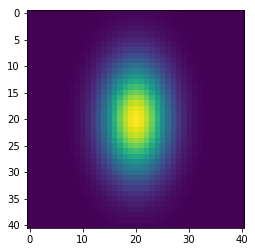

In [61]:
import matplotlib.pyplot as plt
plt.imshow(psf)
plt.show()

In [62]:
center = None
psfs = [psf]


center = [psfs[0].shape[0]//2, psfs[0].shape[1]//2]
x = np.arange(psfs[0].shape[1])
y = np.arange(psfs[0].shape[0])
x,y = np.meshgrid(x,y)
x -= center[1]
y -= center[0]
coords = np.dstack([y,x])
f = scarlet.transformations.LinearFilter(psf, coords)

In [64]:
test = np.zeros((31,21))
test[10,6:15] = 0.5
test[9:12,10] = 0.5
test[10,10] = 1
img = f.dot(test)

In [65]:
%timeit f.dot(test)

11 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


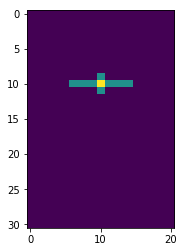

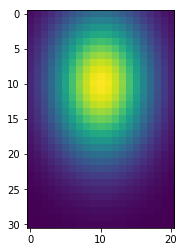

In [66]:
plt.imshow(test)
plt.show()
plt.imshow(img)
plt.show()

In [2]:
def get_filter_slices(coords):
    """Convert a list of relative coordinates to slices

    A `LinearFilter` is defined by an image of weights
    and a list of relative coordinates from the current pixels
    for each weight.
    This method converts those coordinates into slices that are
    used to apply the filter.
    """
    slices = []
    inv_slices = []
    for cy, cx in coords:
        _slice = [slice(None),slice(None)]
        _inv_slice = [slice(None),slice(None)]
        if cy>0:
            _slice[0] = slice(cy,None)
            _inv_slice[0] = slice(None,-cy)
        elif cy<0:
            _slice[0] = slice(None,cy)
            _inv_slice[0] = slice(-cy, None)
        if cx>0:
            _slice[1] = slice(cx,None)
            _inv_slice[1] = slice(None,-cx)
        elif cx<0:
            _slice[1] = slice(None,cx)
            _inv_slice[1] = slice(-cx, None)
        slices.append(_slice)
        inv_slices.append(_inv_slice)
    return slices, inv_slices

In [46]:
def get_filter_masks(coords, shape):
    r = get_filter_slices(coords)
    slices, inv_slices = get_filter_slices(coords)
    masks = []
    inv_masks = []
    for s, inv in zip(slices, inv_slices):
        mask = np.zeros(shape, dtype=bool)
        mask[s] = 1
        masks.append(mask)
        mask = np.zeros(shape, dtype=bool)
        mask[inv] = 1
        inv_masks.append(mask)
    return masks, inv_masks

In [35]:
import imp
imp.reload(scarlet)
imp.reload(scarlet.transformations)

<module 'scarlet.transformations' from '/Users/fred/lsst/code/scarlet/scarlet/transformations.py'>

In [47]:
tx = scarlet.transformations.LinearTranslation(.25,.1)
masks, inv_masks = get_filter_masks(tx.coords, (100,100))
img = np.arange(1e4).reshape(100,100)

In [19]:
%timeit scarlet.transformations.apply_filter(img, tx.img.reshape(-1), tx.slices, tx.inv_slices)

111 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
def apply_filter(X, weights, masks, inv_masks):
    assert len(masks) == len(inv_masks) == len(weights)
    result = np.zeros(X.shape, dtype=X.dtype)
    for n, weight in enumerate(weights):
        result[masks[n]] += weight * X[inv_masks[n]]
    return result.reshape(X.shape)

In [49]:
%timeit apply_filter(img, tx.img.reshape(-1), masks, inv_masks)

168 µs ± 703 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [72]:
shape = (100,100)
idx = np.zeros(shape)
%timeit np.zeros(shape)
%timeit idx[:] = 0

2.82 µs ± 59 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.87 µs ± 64.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
